In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

print('Python', sys.version)

Python 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pytorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [3]:
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential( nn.Linear(dims_in, 100), 
                         nn.ReLU(),
                         nn.Linear(100,  dims_out) )

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    l = l.mean() / ndim
    return l

In [6]:
def train(dataloader, model, optimizer, ndim, scheduler=None):

    size = len(dataloader.dataset)
    model.train()

    for batch, X in enumerate(dataloader):
        # Pass through the network
        z, log_jac_det = model(X)
        
        loss = 0.0
        
        # Get the batch loss
        loss = inn_loss(z, ndim, log_jac_det)

        # Reset the gradients in the optimizer (see autograd tutorial in PyTorch docs)
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Update the network weights
        optimizer.step()
        
        if scheduler != None:
            scheduler.step(loss)

        # Print the loss every 100 updates
        if batch % 100 == 0:
            print(f'INN loss: {loss:>8f}, learning_rate: {optimizer.param_groups[0]["lr"]:>8f}')

In [7]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
valset   = dalitz_dataset(mp_thetap_val)

batch_size = 20000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

epochs = 10
learning_rate = 0.002
min_learning_rate = 1e-6

n_dim = mp_thetap.shape[1]
n_blocks = 10
training_size = len(mp_thetap)

# Define the model
inn = Ff.SequenceINN( n_dim )
for k in range(n_blocks):
    inn.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )

print("Model Architecture: ")
print(inn)

optimizer = torch.optim.Adam(inn.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.90, patience = 100, min_lr = min_learning_rate)
#scheduler = None

for t in tqdm(range(epochs), ncols = 100):
    train(train_dataloader, inn, optimizer,  n_dim, scheduler)
    
print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0-9): 10 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
  )
)


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

INN loss: 0.113507, learning_rate: 0.002000
INN loss: -1.227138, learning_rate: 0.002000
INN loss: -1.323889, learning_rate: 0.002000
INN loss: -1.364935, learning_rate: 0.002000


 10%|██████▍                                                         | 1/10 [01:00<09:07, 60.80s/it]

INN loss: -1.384854, learning_rate: 0.002000
INN loss: -1.403976, learning_rate: 0.002000
INN loss: -1.409463, learning_rate: 0.002000
INN loss: -1.415175, learning_rate: 0.002000


 20%|████████████▊                                                   | 2/10 [02:00<08:00, 60.02s/it]

INN loss: -1.418796, learning_rate: 0.002000
INN loss: -1.420900, learning_rate: 0.002000
INN loss: -1.430117, learning_rate: 0.002000
INN loss: -1.434624, learning_rate: 0.002000


 30%|███████████████████▏                                            | 3/10 [03:01<07:03, 60.53s/it]

INN loss: -1.421668, learning_rate: 0.001800
INN loss: -1.444133, learning_rate: 0.001800
INN loss: -1.437454, learning_rate: 0.001800
INN loss: -1.435542, learning_rate: 0.001620


 40%|█████████████████████████▌                                      | 4/10 [04:02<06:04, 60.79s/it]

INN loss: -1.430574, learning_rate: 0.001458
INN loss: -1.439551, learning_rate: 0.001312
INN loss: -1.448660, learning_rate: 0.001312
INN loss: -1.437042, learning_rate: 0.001181


 50%|████████████████████████████████                                | 5/10 [05:01<05:00, 60.18s/it]

INN loss: -1.441501, learning_rate: 0.001181
INN loss: -1.438299, learning_rate: 0.001181
INN loss: -1.444548, learning_rate: 0.001181
INN loss: -1.456833, learning_rate: 0.001063


 60%|██████████████████████████████████████▍                         | 6/10 [06:00<03:59, 59.80s/it]

INN loss: -1.441903, learning_rate: 0.000957
INN loss: -1.445927, learning_rate: 0.000957
INN loss: -1.443614, learning_rate: 0.000861
INN loss: -1.447930, learning_rate: 0.000775


 70%|████████████████████████████████████████████▊                   | 7/10 [07:00<02:59, 59.81s/it]

INN loss: -1.450611, learning_rate: 0.000697
INN loss: -1.450697, learning_rate: 0.000628
INN loss: -1.447706, learning_rate: 0.000565
INN loss: -1.437009, learning_rate: 0.000508


 80%|███████████████████████████████████████████████████▏            | 8/10 [08:01<02:00, 60.08s/it]

INN loss: -1.454773, learning_rate: 0.000458
INN loss: -1.454934, learning_rate: 0.000458
INN loss: -1.451427, learning_rate: 0.000412
INN loss: -1.457476, learning_rate: 0.000412


 90%|█████████████████████████████████████████████████████████▌      | 9/10 [09:00<00:59, 59.78s/it]

INN loss: -1.455288, learning_rate: 0.000371
INN loss: -1.455725, learning_rate: 0.000334
INN loss: -1.450653, learning_rate: 0.000300
INN loss: -1.455126, learning_rate: 0.000270


100%|███████████████████████████████████████████████████████████████| 10/10 [10:00<00:00, 60.00s/it]

Done!


In [ ]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
valset   = dalitz_dataset(mp_thetap_val)

batch_size = 10000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

epochs = 20
learning_rate = 0.001
min_learning_rate = 1e-6

n_dim = mp_thetap.shape[1]
n_blocks = 10
training_size = len(mp_thetap)

# Define the model
inn = Ff.SequenceINN( n_dim )
for k in range(n_blocks):
    inn.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )

print("Model Architecture: ")
print(inn)

optimizer = torch.optim.Adam(inn.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.90, patience = 100, min_lr = min_learning_rate)
#scheduler = None

for t in tqdm(range(epochs), ncols = 100):
    train(train_dataloader, inn, optimizer,  n_dim, scheduler)
    
print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0-9): 10 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
  )
)


  0%|                                                                        | 0/20 [00:00<?, ?it/s]

Batch 0, INN loss: 0.142592, learning_rate: 0.001000
Batch 100, INN loss: -1.121505, learning_rate: 0.001000
Batch 200, INN loss: -1.227150, learning_rate: 0.001000
Batch 300, INN loss: -1.279975, learning_rate: 0.001000
Batch 400, INN loss: -1.318270, learning_rate: 0.001000
Batch 500, INN loss: -1.354253, learning_rate: 0.001000
Batch 600, INN loss: -1.358151, learning_rate: 0.001000
Batch 700, INN loss: -1.385055, learning_rate: 0.001000


  5%|███▏                                                            | 1/20 [00:51<16:17, 51.46s/it]

Average training loss for this epoch: -1.252240
Batch 0, INN loss: -1.378560, learning_rate: 0.001000
Batch 100, INN loss: -1.381493, learning_rate: 0.001000
Batch 200, INN loss: -1.408252, learning_rate: 0.001000
Batch 300, INN loss: -1.424468, learning_rate: 0.001000
Batch 400, INN loss: -1.410328, learning_rate: 0.001000
Batch 500, INN loss: -1.421649, learning_rate: 0.000900
Batch 600, INN loss: -1.418421, learning_rate: 0.000900
Batch 700, INN loss: -1.436762, learning_rate: 0.000900


 10%|██████▍                                                         | 2/20 [01:42<15:26, 51.50s/it]

Average training loss for this epoch: -1.414367
Batch 0, INN loss: -1.439721, learning_rate: 0.000900
Batch 100, INN loss: -1.422985, learning_rate: 0.000900
Batch 200, INN loss: -1.441041, learning_rate: 0.000900
Batch 300, INN loss: -1.435024, learning_rate: 0.000810
Batch 400, INN loss: -1.435222, learning_rate: 0.000729
Batch 500, INN loss: -1.448647, learning_rate: 0.000656
Batch 600, INN loss: -1.446977, learning_rate: 0.000590
Batch 700, INN loss: -1.438982, learning_rate: 0.000590


 15%|█████████▌                                                      | 3/20 [02:34<14:35, 51.52s/it]

Average training loss for this epoch: -1.441756
Batch 0, INN loss: -1.445679, learning_rate: 0.000590
Batch 100, INN loss: -1.447031, learning_rate: 0.000531
Batch 200, INN loss: -1.454506, learning_rate: 0.000478
Batch 300, INN loss: -1.450138, learning_rate: 0.000430
Batch 400, INN loss: -1.445663, learning_rate: 0.000387
Batch 500, INN loss: -1.441346, learning_rate: 0.000387
Batch 600, INN loss: -1.441820, learning_rate: 0.000387
Batch 700, INN loss: -1.455681, learning_rate: 0.000387


 20%|████████████▊                                                   | 4/20 [03:25<13:39, 51.20s/it]

Average training loss for this epoch: -1.450326
Batch 0, INN loss: -1.459841, learning_rate: 0.000349
Batch 100, INN loss: -1.464118, learning_rate: 0.000314
Batch 200, INN loss: -1.459907, learning_rate: 0.000282
Batch 300, INN loss: -1.446412, learning_rate: 0.000254
Batch 400, INN loss: -1.461277, learning_rate: 0.000229
Batch 500, INN loss: -1.457661, learning_rate: 0.000229
Batch 600, INN loss: -1.456630, learning_rate: 0.000206
Batch 700, INN loss: -1.442666, learning_rate: 0.000185


 25%|████████████████                                                | 5/20 [04:16<12:46, 51.09s/it]

Average training loss for this epoch: -1.454010
Batch 0, INN loss: -1.454452, learning_rate: 0.000167
Batch 100, INN loss: -1.456977, learning_rate: 0.000150
Batch 200, INN loss: -1.464698, learning_rate: 0.000135
Batch 300, INN loss: -1.467456, learning_rate: 0.000122
Batch 400, INN loss: -1.470429, learning_rate: 0.000109
Batch 500, INN loss: -1.453532, learning_rate: 0.000098
Batch 600, INN loss: -1.446155, learning_rate: 0.000089
Batch 700, INN loss: -1.461443, learning_rate: 0.000089


 30%|███████████████████▏                                            | 6/20 [05:06<11:53, 50.99s/it]

Average training loss for this epoch: -1.455684
Batch 0, INN loss: -1.452388, learning_rate: 0.000080
Batch 100, INN loss: -1.462229, learning_rate: 0.000072
Batch 200, INN loss: -1.457134, learning_rate: 0.000065
Batch 300, INN loss: -1.455155, learning_rate: 0.000058
Batch 400, INN loss: -1.460084, learning_rate: 0.000058
Batch 500, INN loss: -1.454095, learning_rate: 0.000052
Batch 600, INN loss: -1.457420, learning_rate: 0.000047
Batch 700, INN loss: -1.456995, learning_rate: 0.000042


 35%|██████████████████████▍                                         | 7/20 [05:57<11:03, 51.01s/it]

Average training loss for this epoch: -1.456441
Batch 0, INN loss: -1.447670, learning_rate: 0.000038
Batch 100, INN loss: -1.455083, learning_rate: 0.000034
Batch 200, INN loss: -1.460469, learning_rate: 0.000031
Batch 300, INN loss: -1.459865, learning_rate: 0.000028
Batch 400, INN loss: -1.457254, learning_rate: 0.000025
Batch 500, INN loss: -1.459403, learning_rate: 0.000023
Batch 600, INN loss: -1.461591, learning_rate: 0.000020
Batch 700, INN loss: -1.461221, learning_rate: 0.000018


 40%|█████████████████████████▌                                      | 8/20 [06:50<10:17, 51.48s/it]

Average training loss for this epoch: -1.456824
Batch 0, INN loss: -1.461692, learning_rate: 0.000016
Batch 100, INN loss: -1.453263, learning_rate: 0.000015
Batch 200, INN loss: -1.463428, learning_rate: 0.000013
Batch 300, INN loss: -1.464708, learning_rate: 0.000012
Batch 400, INN loss: -1.458721, learning_rate: 0.000012
Batch 500, INN loss: -1.465688, learning_rate: 0.000011
Batch 600, INN loss: -1.453999, learning_rate: 0.000010
Batch 700, INN loss: -1.458972, learning_rate: 0.000009


 45%|████████████████████████████▊                                   | 9/20 [07:43<09:31, 51.99s/it]

Average training loss for this epoch: -1.456995
Batch 0, INN loss: -1.449196, learning_rate: 0.000008
Batch 100, INN loss: -1.457408, learning_rate: 0.000007
Batch 200, INN loss: -1.446129, learning_rate: 0.000006
Batch 300, INN loss: -1.464175, learning_rate: 0.000006
Batch 400, INN loss: -1.467783, learning_rate: 0.000005
Batch 500, INN loss: -1.461891, learning_rate: 0.000005
Batch 600, INN loss: -1.443884, learning_rate: 0.000004
Batch 700, INN loss: -1.453933, learning_rate: 0.000004


 50%|███████████████████████████████                               | 10/20 [18:27<39:06, 234.67s/it]

Average training loss for this epoch: -1.457080
Batch 0, INN loss: -1.455720, learning_rate: 0.000003
Batch 100, INN loss: -1.452960, learning_rate: 0.000003
Batch 200, INN loss: -1.460105, learning_rate: 0.000003
Batch 300, INN loss: -1.449108, learning_rate: 0.000002
Batch 400, INN loss: -1.465228, learning_rate: 0.000002
Batch 500, INN loss: -1.448969, learning_rate: 0.000002
Batch 600, INN loss: -1.464160, learning_rate: 0.000002
Batch 700, INN loss: -1.449826, learning_rate: 0.000002


 55%|█████████████████████████████████                           | 11/20 [58:30<2:14:44, 898.25s/it]

Average training loss for this epoch: -1.457119
Batch 0, INN loss: -1.463348, learning_rate: 0.000001
Batch 100, INN loss: -1.454002, learning_rate: 0.000001
Batch 200, INN loss: -1.452313, learning_rate: 0.000001
Batch 300, INN loss: -1.451470, learning_rate: 0.000001
Batch 400, INN loss: -1.459661, learning_rate: 0.000001
Batch 500, INN loss: -1.456477, learning_rate: 0.000001
Batch 600, INN loss: -1.443594, learning_rate: 0.000001
Batch 700, INN loss: -1.456843, learning_rate: 0.000001


 60%|██████████████████████████████████▏                      | 12/20 [1:59:42<3:52:16, 1742.12s/it]

Average training loss for this epoch: -1.457136
Batch 0, INN loss: -1.449516, learning_rate: 0.000001
Batch 100, INN loss: -1.453935, learning_rate: 0.000001
Batch 200, INN loss: -1.454229, learning_rate: 0.000001
Batch 300, INN loss: -1.448602, learning_rate: 0.000001
Batch 400, INN loss: -1.457769, learning_rate: 0.000001
Batch 500, INN loss: -1.467123, learning_rate: 0.000001
Batch 600, INN loss: -1.466459, learning_rate: 0.000001
Batch 700, INN loss: -1.455318, learning_rate: 0.000001


 65%|█████████████████████████████████████                    | 13/20 [2:13:53<2:51:44, 1472.10s/it]

Average training loss for this epoch: -1.457145
Batch 0, INN loss: -1.463076, learning_rate: 0.000001
Batch 100, INN loss: -1.452647, learning_rate: 0.000001
Batch 200, INN loss: -1.457006, learning_rate: 0.000001
Batch 300, INN loss: -1.455188, learning_rate: 0.000001
Batch 400, INN loss: -1.453478, learning_rate: 0.000001
Batch 500, INN loss: -1.460252, learning_rate: 0.000001
Batch 600, INN loss: -1.462361, learning_rate: 0.000001
Batch 700, INN loss: -1.456408, learning_rate: 0.000001


 70%|███████████████████████████████████████▉                 | 14/20 [2:14:44<1:44:17, 1042.97s/it]

Average training loss for this epoch: -1.457155
Batch 0, INN loss: -1.452766, learning_rate: 0.000001
Batch 100, INN loss: -1.457327, learning_rate: 0.000001
Batch 200, INN loss: -1.449451, learning_rate: 0.000001
Batch 300, INN loss: -1.453837, learning_rate: 0.000001
Batch 400, INN loss: -1.453029, learning_rate: 0.000001
Batch 500, INN loss: -1.460418, learning_rate: 0.000001
Batch 600, INN loss: -1.453642, learning_rate: 0.000001
Batch 700, INN loss: -1.460043, learning_rate: 0.000001


 75%|███████████████████████████████████████████▌              | 15/20 [2:15:36<1:02:00, 744.10s/it]

Average training loss for this epoch: -1.457164
Batch 0, INN loss: -1.465699, learning_rate: 0.000001
Batch 100, INN loss: -1.445498, learning_rate: 0.000001
Batch 200, INN loss: -1.465655, learning_rate: 0.000001
Batch 300, INN loss: -1.453374, learning_rate: 0.000001
Batch 400, INN loss: -1.445759, learning_rate: 0.000001
Batch 500, INN loss: -1.454834, learning_rate: 0.000001
Batch 600, INN loss: -1.456762, learning_rate: 0.000001
Batch 700, INN loss: -1.464777, learning_rate: 0.000001


 80%|████████████████████████████████████████████████            | 16/20 [2:16:27<35:42, 535.65s/it]

Average training loss for this epoch: -1.457174
Batch 0, INN loss: -1.463063, learning_rate: 0.000001
Batch 100, INN loss: -1.454374, learning_rate: 0.000001
Batch 200, INN loss: -1.463682, learning_rate: 0.000001
Batch 300, INN loss: -1.441692, learning_rate: 0.000001
Batch 400, INN loss: -1.471167, learning_rate: 0.000001
Batch 500, INN loss: -1.446098, learning_rate: 0.000001
Batch 600, INN loss: -1.456824, learning_rate: 0.000001
Batch 700, INN loss: -1.466929, learning_rate: 0.000001


 85%|███████████████████████████████████████████████████         | 17/20 [2:17:18<19:29, 389.90s/it]

Average training loss for this epoch: -1.457183
Batch 0, INN loss: -1.466339, learning_rate: 0.000001
Batch 100, INN loss: -1.457111, learning_rate: 0.000001
Batch 200, INN loss: -1.448576, learning_rate: 0.000001
Batch 300, INN loss: -1.469795, learning_rate: 0.000001
Batch 400, INN loss: -1.450655, learning_rate: 0.000001
Batch 500, INN loss: -1.454068, learning_rate: 0.000001
Batch 600, INN loss: -1.455344, learning_rate: 0.000001
Batch 700, INN loss: -1.458093, learning_rate: 0.000001


 90%|██████████████████████████████████████████████████████      | 18/20 [2:18:10<09:36, 288.23s/it]

Average training loss for this epoch: -1.457192
Batch 0, INN loss: -1.469418, learning_rate: 0.000001
Batch 100, INN loss: -1.455824, learning_rate: 0.000001
Batch 200, INN loss: -1.458234, learning_rate: 0.000001
Batch 300, INN loss: -1.466366, learning_rate: 0.000001
Batch 400, INN loss: -1.462643, learning_rate: 0.000001
Batch 500, INN loss: -1.454727, learning_rate: 0.000001
Batch 600, INN loss: -1.460123, learning_rate: 0.000001
Batch 700, INN loss: -1.458315, learning_rate: 0.000001


 95%|█████████████████████████████████████████████████████████   | 19/20 [2:19:01<03:37, 217.08s/it]

Average training loss for this epoch: -1.457201
Batch 0, INN loss: -1.460836, learning_rate: 0.000001
Batch 100, INN loss: -1.455324, learning_rate: 0.000001
Batch 200, INN loss: -1.468649, learning_rate: 0.000001
Batch 300, INN loss: -1.460964, learning_rate: 0.000001
Batch 400, INN loss: -1.462173, learning_rate: 0.000001
Batch 500, INN loss: -1.455990, learning_rate: 0.000001
Batch 600, INN loss: -1.452166, learning_rate: 0.000001
Batch 700, INN loss: -1.448831, learning_rate: 0.000001


100%|████████████████████████████████████████████████████████████| 20/20 [2:19:52<00:00, 419.64s/it]

Average training loss for this epoch: -1.457211
Done!


torch.Size([100000, 2])


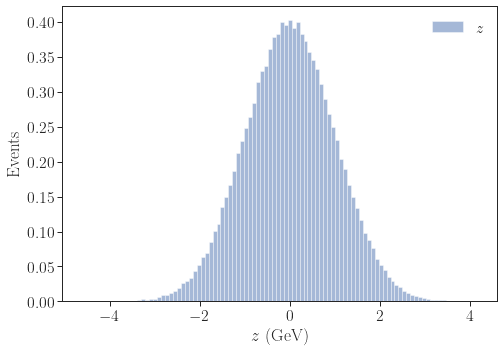

In [8]:
# Latent distribution
n_samples = 100000
z_gen = torch.randn((n_samples, n_dim))

print(z_gen.shape)

# Visualize the latent distribution
fig, axs = plt.subplots(figsize=(7,5))

axs.hist(z_gen.detach().numpy().flatten(), alpha=0.5, density=True, bins=100, label=r'$z$')

axs.set_xlabel('$z$ $(\mathrm{GeV})$')
axs.set_ylabel( r'$\mathrm{Events}$' )
axs.legend(loc='best', frameon=False)

fig.tight_layout()

In [9]:
# Generate m2 samples from latent distribution
mp_thetap_gen, _ = inn(z_gen, rev=True)
mp_thetap_gen = mp_thetap_gen.detach().numpy()[:]

print(mp_thetap_gen.shape)
print(mp_thetap_gen[0])

(100000, 2)
[0.13067612 0.27207273]


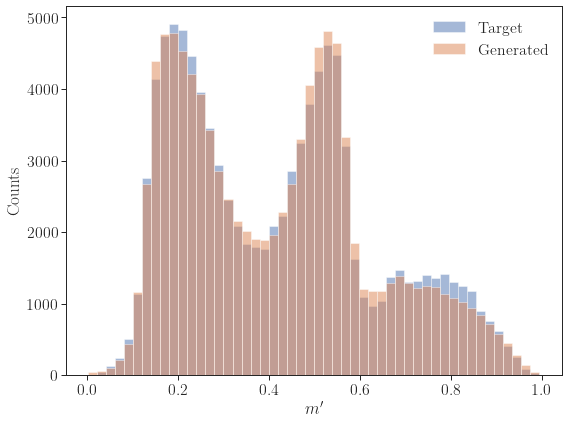

In [10]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

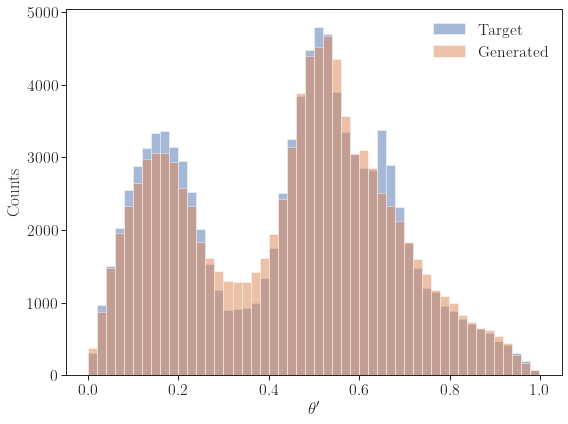

In [11]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

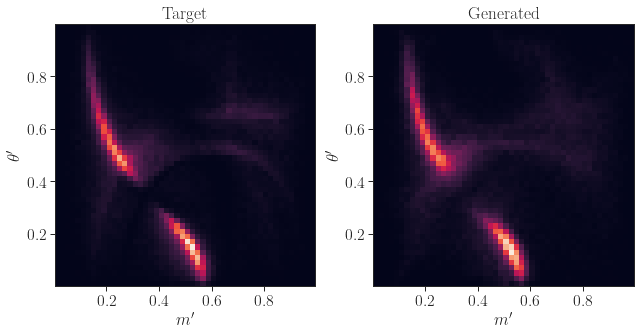

In [12]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5) )

h, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 50)
ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges])

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

#ax.legend(loc='best', frameon=False)
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [ ]:
# Define the model creation function
def create_model(base='gauss'):
    K = 8  # Number of flow layers
    latent_size = 2

    # Coupling mask
    b = torch.tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

    # Define flows
    flows = []
    for i in range(K):
        param_map = nf.nets.MLP([latent_size // 2, 32, 32, latent_size], init_zeros=True)
        flows += [nf.flows.AffineCouplingBlock(param_map)]
        flows += [nf.flows.Permute(latent_size, mode='swap')]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0            
    if base == 'resampled':
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)

    elif base == 'gaussian_mixture':
        n_modes = 10
        loc = (np.random.rand(n_modes, latent_size) - 0.5) * 5
        scale = 0.5 * np.ones((n_modes, latent_size))
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True, loc=loc, scale=scale)
    elif base == 'gauss':
        q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    else:
        raise NotImplementedError(f"Base distribution '{base}' is not implemented.")

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows)

    return model.to(device)


# Training function
def train(dataloader, model, optimizer, scheduler=None):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if scheduler:
        scheduler.step(total_loss / len(dataloader))
    print(f"Training Loss: {total_loss / len(dataloader)}")


In [35]:
import normflows as nf
import larsflow as lf
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load data
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert data into PyTorch tensors
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val = torch.Tensor(mp_thetap_val)

# Define a custom dataset class
class dalitz_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Prepare datasets and data loaders
trainset = dalitz_dataset(mp_thetap_train)
valset = dalitz_dataset(mp_thetap_val)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Training set size:  (8000000, 2) Validation set size:  (2000000, 2)


In [41]:
# Create model
model = create_model()

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, min_lr=min_learning_rate)


# Training loop
for t in tqdm(range(epochs), ncols=100):
    train(train_dataloader, model, optimizer, scheduler)

print("Done!")

  0%|                                                                        | 0/20 [01:58<?, ?it/s]


KeyboardInterrupt: 

In [36]:
# Create a new model instance
model2 = create_model(base='resampled')

batch_size = 1000 
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model parameters
epochs = 20
learning_rate = 0.002
min_learning_rate = 1e-6

# Optimizer and scheduler
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.9, patience=100, min_lr=min_learning_rate)

# Training loop
for epoch in tqdm(range(epochs), ncols=100):
    train(train_dataloader, model2, optimizer, scheduler)

print("Done!")

  5%|███                                                          | 1/20 [03:57<1:15:07, 237.21s/it]

Training Loss: -1.087936898322776


 10%|██████                                                       | 2/20 [07:53<1:10:59, 236.63s/it]

Training Loss: -1.1062050242125987


 15%|█████████▏                                                   | 3/20 [11:50<1:07:02, 236.63s/it]

Training Loss: -1.1103429152965545


 20%|████████████▏                                                | 4/20 [15:53<1:03:50, 239.39s/it]

Training Loss: -1.112628929927945


 25%|███████████████▊                                               | 5/20 [19:53<59:51, 239.40s/it]

Training Loss: -1.1137840725183488


 30%|██████████████████▉                                            | 6/20 [23:54<55:59, 239.97s/it]

Training Loss: -1.11064640814811


 35%|██████████████████████                                         | 7/20 [27:53<51:57, 239.79s/it]

Training Loss: -1.1139978974089026


 40%|████████████████████████▍                                    | 8/20 [37:14<1:08:22, 341.88s/it]

Training Loss: -1.1150212681293488


 45%|███████████████████████████▍                                 | 9/20 [47:15<1:17:31, 422.91s/it]

Training Loss: -1.114150277659297


 50%|███████████████████████████████                               | 10/20 [50:49<59:44, 358.49s/it]

Training Loss: -1.1156408879682422


 50%|███████████████████████████████                               | 10/20 [51:28<51:28, 308.84s/it]


KeyboardInterrupt: 

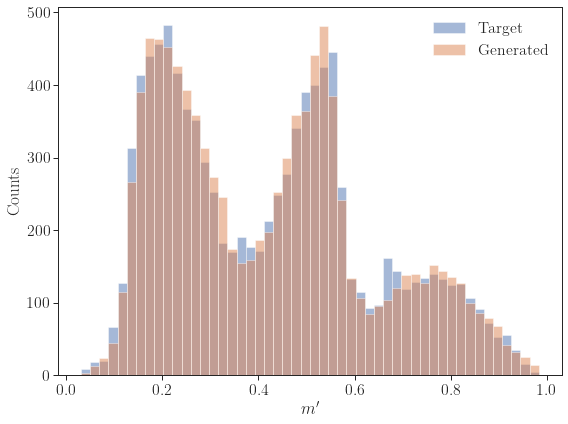

In [37]:
import matplotlib.pyplot as plt

# Generate samples from the trained model
model2.eval()
with torch.no_grad():
    samples = model2.sample(10000)
    if isinstance(samples, tuple):
        samples = samples[0]  # Extract the tensor if it's a tuple
    generated_samples = samples.cpu().numpy()

# Number of samples to visualize
n_samples = 10000

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))

# Plot target distribution
counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

# Plot generated samples
ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$\mathrm{Counts}$')

ax.legend(loc='best', frameon=False)

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.png', dpi=300, pad_inches=.1, bbox_inches='tight')

plt.show()

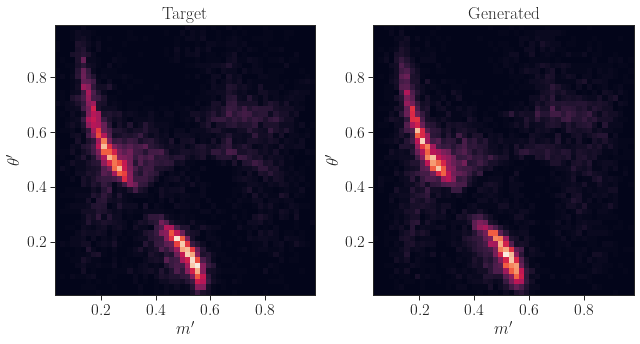

In [40]:
import matplotlib.pyplot as plt

# Generate samples from the trained model
model2.eval()
with torch.no_grad():
    samples = model2.sample(10000)
    if isinstance(samples, tuple):
        samples = samples[0]  # Extract the tensor if it's a tuple
    mp_thetap_gen = samples.cpu().numpy()

# Number of samples to visualize
n_samples = 10000

# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

h, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples, 0], mp_thetap[:n_samples, 1], 50)
ax2.hist2d(mp_thetap_gen[:, 0], mp_thetap_gen[:, 1], bins=[xedges, yedges])

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi=300, pad_inches=.1, bbox_inches='tight')

plt.show()

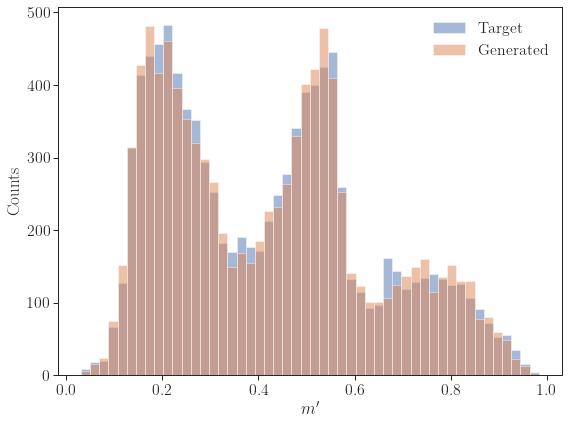

In [52]:
import matplotlib.pyplot as plt

# Generate samples from the trained model
model.eval()
with torch.no_grad():
    samples = model.sample(10000)
    if isinstance(samples, tuple):
        samples = samples[0]  # Extract the tensor if it's a tuple
    generated_samples = samples.cpu().numpy()

# Number of samples to visualize
n_samples = 10000

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))

# Plot target distribution
counts, bins, _ = ax.hist(mp_thetap[:n_samples, 0], 50, alpha=0.5, label=r'$\mathrm{Target}$')

# Plot generated samples
ax.hist(generated_samples[:n_samples, 0], bins=bins, alpha=0.5, label=r'$\mathrm{Generated}$')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$\mathrm{Counts}$')

ax.legend(loc='best', frameon=False)

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.pdf', dpi=300, pad_inches=.1, bbox_inches='tight')
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.png', dpi=300, pad_inches=.1, bbox_inches='tight')

plt.show()